In [4]:
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np

def display_images(data, max_n = 8):
    n = 8
    fig, ax = plt.subplots(1, n)
    for i in range(n):
        img = data[0][i].cpu().numpy()
        ax[i].imshow(img.transpose((1, 2, 0)))
        ax[i].axis("off")
    fig.set_size_inches(fig.get_size_inches() * n)
    plt.tight_layout()
    plt.show()

In [5]:
! pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import torch
import torchvision
import torchinfo
import time
import sklearn
from sklearn.model_selection import train_test_split

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [8]:
img_size = (224,224)
batch_size = 100

from torch.utils.data.dataloader import default_collate

def data_to_device(x):
    return tuple(x_.to(device) for x_ in default_collate(x))

train_transform = torchvision.transforms.Compose([
            torchvision.transforms.Resize(img_size),
            torchvision.transforms.RandomHorizontalFlip(0.3),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

data = torchvision.datasets.OxfordIIITPet('data', download = True, transform = train_transform)
train_x, test_x = torch.utils.data.random_split(data, [len(data) * 8 // 10, len(data) - len(data) * 8 // 10])

dataloadertrain = torch.utils.data.DataLoader(train_x, batch_size = batch_size, collate_fn = data_to_device)
dataloadertest = torch.utils.data.DataLoader(test_x, batch_size = 1, collate_fn = data_to_device)


  0%|          | 0/791918971 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/images.tar.gz to data/oxford-iiit-pet


  0%|          | 0/19173078 [00:00<?, ?it/s]

Extracting data/oxford-iiit-pet/annotations.tar.gz to data/oxford-iiit-pet


In [9]:
data.classes

['Abyssinian',
 'American Bulldog',
 'American Pit Bull Terrier',
 'Basset Hound',
 'Beagle',
 'Bengal',
 'Birman',
 'Bombay',
 'Boxer',
 'British Shorthair',
 'Chihuahua',
 'Egyptian Mau',
 'English Cocker Spaniel',
 'English Setter',
 'German Shorthaired',
 'Great Pyrenees',
 'Havanese',
 'Japanese Chin',
 'Keeshond',
 'Leonberger',
 'Maine Coon',
 'Miniature Pinscher',
 'Newfoundland',
 'Persian',
 'Pomeranian',
 'Pug',
 'Ragdoll',
 'Russian Blue',
 'Saint Bernard',
 'Samoyed',
 'Scottish Terrier',
 'Shiba Inu',
 'Siamese',
 'Sphynx',
 'Staffordshire Bull Terrier',
 'Wheaten Terrier',
 'Yorkshire Terrier']

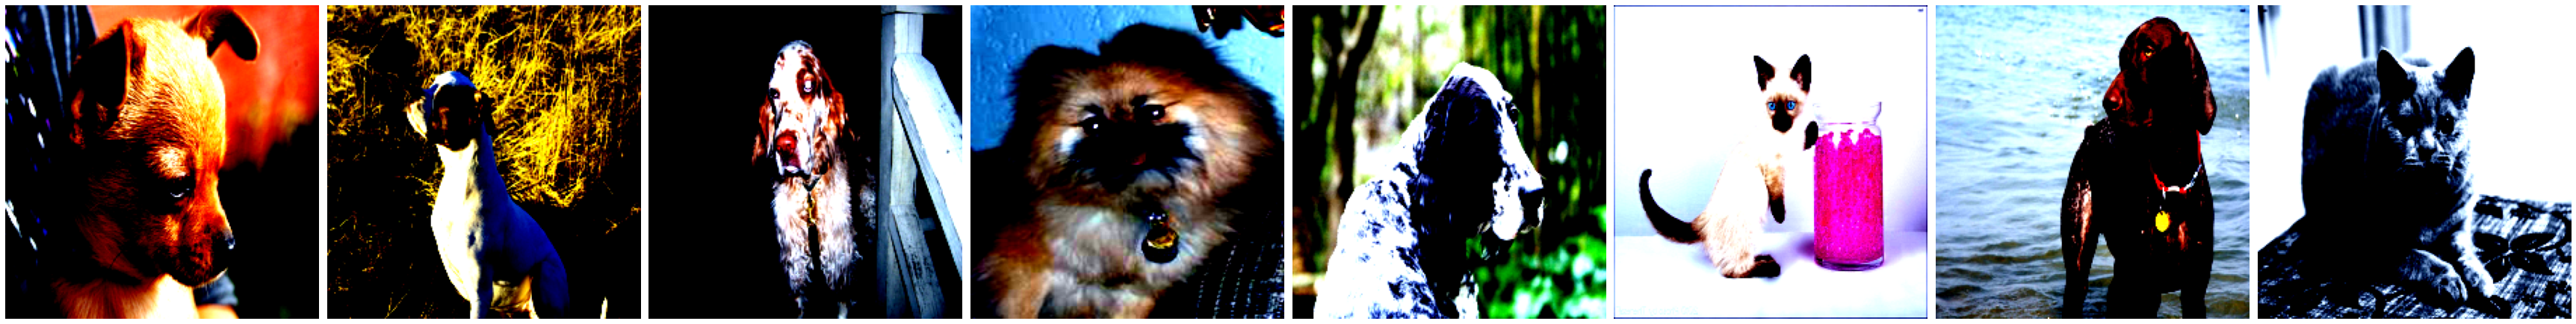

In [10]:
display_images(list(dataloadertrain)[0])

In [11]:

def one_hot_encoding(old_y, z):
    y = torch.tensor((), dtype = torch.float32).new_zeros(z.size())
    for i in range(z.size(0)):
        y[i][old_y[i].long().item()] = 1
    return y

def acc_loss(net, dataloader):
    with torch.no_grad():
        k = 0
        for (x, y) in dataloader:
                z = net(x)
                z = (torch.argmax(torch.softmax(z, 1), axis = 1) == y).sum().item()
                k += z
    return k / len(dataloader)

def top_k_accuracy(net, test, k):
    kans = 0
    total = len(test)
    with torch.no_grad():
        for (x, y) in test:

            z = 1 - torch.softmax(net(x), 1).cpu().numpy()[0]
            p = np.argpartition(z, k-1)[:k]
            if y[0].item() in p:
                kans += 1
    return kans / len(test)

def debug_acc(net, val_x, val_lab, ep, loss):
    k = 0
    a = net(val_x.float())
    for i in range(val_lab.size(0)):
        b = torch.argmax(a[i])
        if b == val_lab[i]:
            k += 1
    print(f"Epoch {ep}: last batch loss = {loss}, val acc = {k / val_lab.size(0)}")

In [12]:
def train(net, l, optim, dataloader, test, epochs = 10):
    graphics = [[], [], [], []]
    for ep in range(epochs):
        loss = 0
        k = 0
        for (x, y) in dataloader: 
            z = net(x)
            loss = l(z, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            k += (torch.argmax(torch.softmax(z, 1), axis = 1) == y).sum().item()
        graphics[0].append(k / len(dataloader.dataset))
        ac = acc_loss(net, test)
        graphics[1].append(ac)
        ac = top_k_accuracy(net, test, 3)
        graphics[2].append(ac)
        ac = top_k_accuracy(net, test, 5)
        graphics[3].append(ac)
    return graphics

In [13]:
def draw_confusion_matrix_and_graphics(net, dataloader, n, graphics):
    con_matrix = []
    for i in range(n):
        con_matrix.append([0] * n)
        
    for x, y in dataloader: 
        z = net(x)
        con_matrix[torch.argmax(torch.softmax(z, 1))][y] += 1
            
    figure = plt.figure(figsize = (17, 5))
    axes = figure.add_subplot(121)
    caxes = axes.matshow(con_matrix)
    figure.colorbar(caxes)
        
    axes = figure.add_subplot(122)
    plt.plot(graphics[0], 'r')
    plt.plot(graphics[1], 'b')
    plt.plot(graphics[2], 'g')
    plt.plot(graphics[3], 'y')
    plt.show()

In [14]:
vgg16 = torchvision.models.vgg16(pretrained=True)
vgg16.to(device)

print(vgg16.classifier)

vgg16.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096), 
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Linear(4096, 37)).to(device)

for x in vgg16.features.parameters():
    x.requires_grad = False

torchinfo.summary(vgg16, (1, 3,244,244))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
VGG                                      [1, 37]                   --
├─Sequential: 1-1                        [1, 512, 7, 7]            --
│    └─Conv2d: 2-1                       [1, 64, 244, 244]         (1,792)
│    └─ReLU: 2-2                         [1, 64, 244, 244]         --
│    └─Conv2d: 2-3                       [1, 64, 244, 244]         (36,928)
│    └─ReLU: 2-4                         [1, 64, 244, 244]         --
│    └─MaxPool2d: 2-5                    [1, 64, 122, 122]         --
│    └─Conv2d: 2-6                       [1, 128, 122, 122]        (73,856)
│    └─ReLU: 2-7                         [1, 128, 122, 122]        --
│    └─Conv2d: 2-8                       [1, 128, 122, 122]        (147,584)
│    └─ReLU: 2-9                         [1, 128, 122, 122]        --
│    └─MaxPool2d: 2-10                   [1, 128, 61, 61]          --
│    └─Conv2d: 2-11                      [1, 256, 61, 61]    

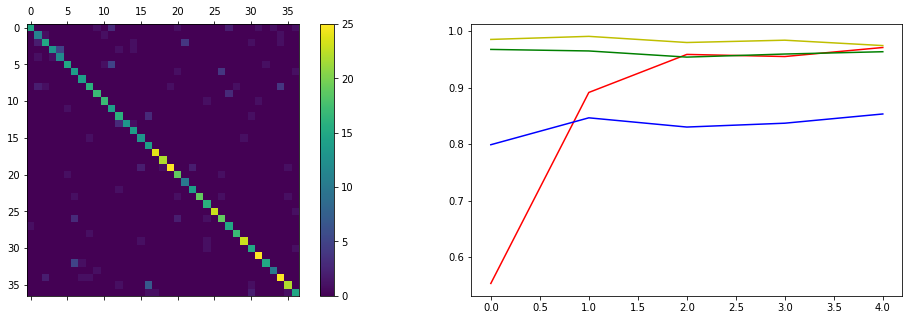

Final accuracy = 96.2: 
Test accuracy = 0.8396739130434783: 


In [15]:
optim = torch.optim.Adam(vgg16.parameters(), lr = 0.00075)
loss = torch.nn.functional.cross_entropy
graphics = train(vgg16, loss, optim, dataloadertrain, dataloadertest, epochs = 5)
draw_confusion_matrix_and_graphics(vgg16, dataloadertest, 37, graphics)
print("Final accuracy = {}: ".format(acc_loss(vgg16, dataloadertrain)))
print("Test accuracy = {}: ".format(acc_loss(vgg16, dataloadertest)))


Точность для классификации "Кошка-собака"

In [16]:
bin_acc = 0
cats = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
for (x, y) in dataloadertest:
    z = vgg16(x)
    z = torch.argmax(torch.softmax(z, 1), axis = 1)

    if (y[0] in cats) == (z[0] in cats):
        bin_acc += 1

print(bin_acc / len(dataloadertest))

0.9904891304347826


In [17]:
resnet = torchvision.models.resnet50(pretrained=True)
resnet.to(device)

print(resnet.fc)

resnet.fc = torch.nn.Sequential(torch.nn.Linear(2048, 4096), 
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(4096, 4096),
                                    torch.nn.ReLU(),
                                    torch.nn.Linear(4096, 37)).to(device)
for x in resnet.parameters():
    x.requires_grad = False

for x in resnet.fc.parameters():
    x.requires_grad = True

torchinfo.summary(resnet, (1, 3,244,244))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Linear(in_features=2048, out_features=1000, bias=True)


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [1, 37]                   --
├─Conv2d: 1-1                            [1, 64, 122, 122]         (9,408)
├─BatchNorm2d: 1-2                       [1, 64, 122, 122]         (128)
├─ReLU: 1-3                              [1, 64, 122, 122]         --
├─MaxPool2d: 1-4                         [1, 64, 61, 61]           --
├─Sequential: 1-5                        [1, 256, 61, 61]          --
│    └─Bottleneck: 2-1                   [1, 256, 61, 61]          --
│    │    └─Conv2d: 3-1                  [1, 64, 61, 61]           (4,096)
│    │    └─BatchNorm2d: 3-2             [1, 64, 61, 61]           (128)
│    │    └─ReLU: 3-3                    [1, 64, 61, 61]           --
│    │    └─Conv2d: 3-4                  [1, 64, 61, 61]           (36,864)
│    │    └─BatchNorm2d: 3-5             [1, 64, 61, 61]           (128)
│    │    └─ReLU: 3-6                    [1, 64, 61, 61]    

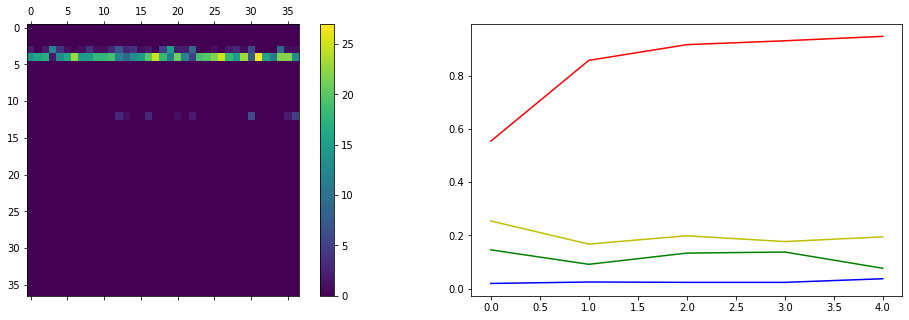

Final accuracy = 92.83333333333333: 
Test accuracy = 0.03804347826086957: 


In [18]:
optim = torch.optim.Adam(resnet.parameters(), lr = 0.0001)
loss = torch.nn.functional.cross_entropy
graphics = train(resnet, loss, optim, dataloadertrain, dataloadertest, epochs = 5)
draw_confusion_matrix_and_graphics(resnet, dataloadertest, 37, graphics)
print("Final accuracy = {}: ".format(acc_loss(resnet, dataloadertrain)))
print("Test accuracy = {}: ".format(acc_loss(resnet, dataloadertest)))

Точность для классификации "Кошка-собака"

In [19]:
bin_acc = 0
cats = [0, 5, 6, 7, 9, 11, 20, 23, 26, 27, 32, 33]
for (x, y) in dataloadertest:
    z = resnet(x)
    z = torch.argmax(torch.softmax(z, 1), axis = 1)

    if (y[0] in cats) == (z[0] in cats):
        bin_acc += 1

print(bin_acc / len(dataloadertest))

0.6902173913043478
